# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
x_train = train['X']
y_train = train['y']

x_test = train['X']
y_test = train['y']

# Reshaping the data to a more comfortable one
x_train = np.transpose(x_train,(3, 0, 1, 2))
x_test = np.transpose(x_test,(3, 0, 1, 2))

print('Shape of the train data: ', x_train.shape)
print('Shape of the train labels: ', y_train.shape)

print('Shape of the test data: ', x_test.shape)
print('Shape of the test labels: ', y_test.shape)

Shape of the train data:  (73257, 32, 32, 3)
Shape of the train labels:  (73257, 1)
Shape of the test data:  (73257, 32, 32, 3)
Shape of the test labels:  (73257, 1)


As we can see, the dimensions of the image, including the channels, come first, and the amount of examples comes at last. Knowing this is really important to get to know our data and to train our model. We also know from the shapes that the number of examples in the training set is equal to the number of examples in the test set.  
Let's take a look at some images from the training dataset.

/home/ricardo/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


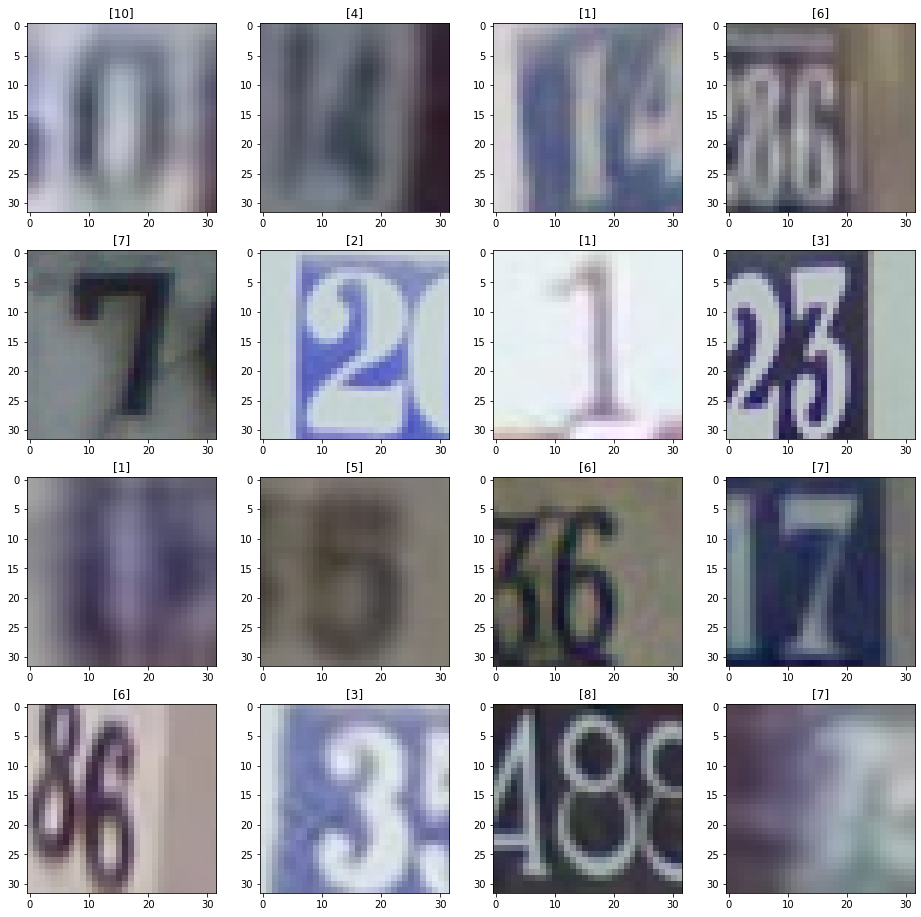

In [4]:
fig, ax = plt.subplots(4, 4, figsize = (16, 16))

for i in range(4):
    for j in range(4):
        index = random.randint(0, x_train.shape[0] - 1)
        image = x_train[index, :, :, :]
        
        ax[i][j].imshow(image)
        ax[i][j].set_title(y_train[index, :])

Playing with the code above we can observe some things:  

* More than one number can appear on the image, but it seems like the one on the center of the image is the one we need to predict  
* Images with a 0 have a label 10
* Images are extremely blurry  

Let's know convert the images to grayscale. The instructions tells us to use a mean, but that is a bad idea, there are way better methods for it, as the one from the function `rgb2gray`

In [5]:
def rgb2gray(image):
    return np.dot(image, [0.2989, 0.5870, 0.1140])

New shapes of the images
Shape of training data:  (73257, 32, 32)
Shape of test data:  (73257, 32, 32)


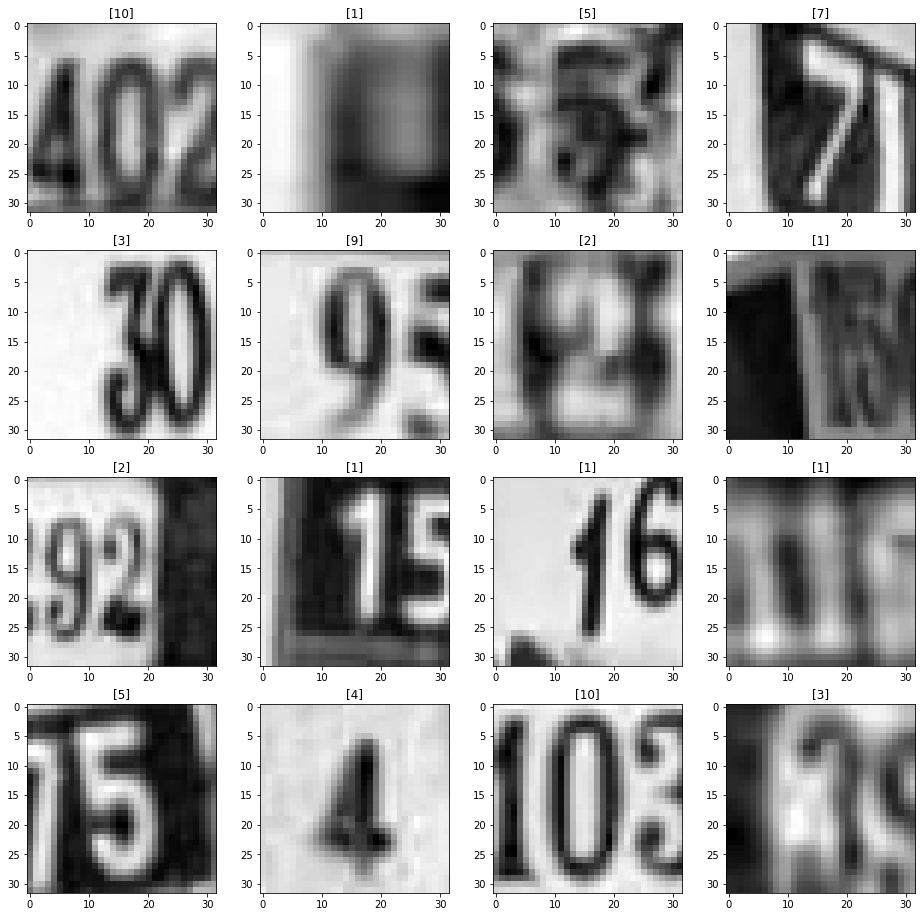

In [6]:
gs_x_train = np.zeros((x_train.shape[0], 32, 32))
gs_x_test = np.zeros((x_test.shape[0], 32, 32))

for i in range(x_train.shape[0]):
    gs_x_train[i] = rgb2gray(x_train[i])
    gs_x_test[i] = rgb2gray(x_test[i])

print('New shapes of the images')
print('Shape of training data: ', gs_x_train.shape)
print('Shape of test data: ', gs_x_test.shape)

fig, ax = plt.subplots(4, 4, figsize = (16, 16))

for i in range(4):
    for j in range(4):
        index = random.randint(0, gs_x_train.shape[0] - 1)
        image = gs_x_train[index, :, :]
        
        ax[i][j].imshow(image, cmap = 'gray')
        ax[i][j].set_title(y_train[index, :])

The last step remaining is to normalize the values of the images. Image values are stored in 8 bits, so the values range from 0 to 255. To normalize it all we have to do is divide the images by 255 and the values will now range from 0 to 1.

In [7]:
gs_x_train = gs_x_train / 255
gs_x_test = gs_x_test / 255

Now our data is ready to be feed into the model.

In [8]:
def get_stats(model, x_test, y_test):
    st = model.evaluate(x_test, y_test, verbose = 0)
    
    return st[0], st[1]

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
from tensorflow.keras.optimizers import Adam

def get_mlp_model():
    
    model = Sequential([
        Flatten(input_shape = (32, 32, 1)),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(11, activation = 'softmax')
    ])
    
    checkpoint = ModelCheckpoint(filepath = 'mode_checkpoint/checkpoint',
                                 monitor = 'val_loss',
                                 verbose = 1)
    
    e_stopping = EarlyStopping(monitor = 'val_acc',
                               patience = 6)
    
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc']
    )
    
    
    return model, [checkpoint, e_stopping]

In [10]:
mlp_model, callbacks = get_mlp_model()

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                3

In [11]:
history_mlp = mlp_model.fit(gs_x_train[...,np.newaxis], y_train, epochs = 30, validation_split = 0.15, verbose = 1,
             batch_size = 128, callbacks = callbacks)

Epoch 1/30
483/487 [============================>.] - ETA: 0s - loss: 2.2517 - acc: 0.1876
Epoch 00001: saving model to mode_checkpoint/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [==============================] - 3s 6ms/step - loss: 2.2517 - acc: 0.1874 - val_loss: 2.2397 - val_acc: 0.1881
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 2.1511 - acc: 0.2199
Epoch 00002: saving model to mode_checkpoint/checkpoint
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [==============================] - 3s 6ms/step - loss: 2.1510 - acc: 0.2199 - val_loss: 2.0287 - val_acc: 0.2551
Epoch 3/30
472/487 [============================>.] - ETA: 0s - loss: 1.8093 - acc: 0.3519
Epoch 00003: saving model to mode_checkpoint/checkpoint
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [====================

484/487 [============================>.] - ETA: 0s - loss: 1.0897 - acc: 0.6527
Epoch 00024: saving model to mode_checkpoint/checkpoint
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [==============================] - 3s 6ms/step - loss: 1.0898 - acc: 0.6528 - val_loss: 1.0908 - val_acc: 0.6541
Epoch 25/30
473/487 [============================>.] - ETA: 0s - loss: 1.0815 - acc: 0.6552
Epoch 00025: saving model to mode_checkpoint/checkpoint
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [==============================] - 3s 6ms/step - loss: 1.0828 - acc: 0.6547 - val_loss: 1.0973 - val_acc: 0.6485
Epoch 26/30
474/487 [============================>.] - ETA: 0s - loss: 1.0832 - acc: 0.6540
Epoch 00026: saving model to mode_checkpoint/checkpoint
INFO:tensorflow:Assets written to: mode_checkpoint/checkpoint/assets
487/487 [==============================] - 3s 5ms/step - loss: 1.0838 - acc: 0.6538 - val_loss: 1.1265 - val_acc: 0.637

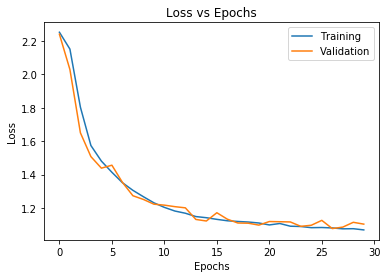

In [12]:
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

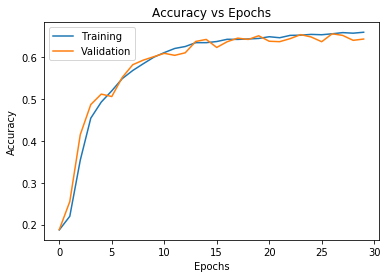

In [13]:
plt.plot(history_mlp.history['acc'])
plt.plot(history_mlp.history['val_acc'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

In [14]:
test_loss, test_accuracy = get_stats(mlp_model, gs_x_test[..., np.newaxis], y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Test loss: 1.0755985975265503
Test accuracy: 0.6557189226150513


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [17]:
def get_cnn_model():
    model = Sequential([
        Conv2D(32, 3, padding = 'SAME', activation = 'relu', input_shape = (32, 32, 1)),
        MaxPooling2D(4),
        Conv2D(32, 3, padding = 'SAME', activation = 'relu'),
        Flatten(),
        Dense(11, activation = 'softmax')
    ])
    
    checkpoint = ModelCheckpoint(filepath = 'cnn_model_checkpoint/checkpoint',
                                 monitor = 'val_loss',
                                 verbose = 1)
    
    e_stopping = EarlyStopping(monitor = 'val_acc',
                               patience = 6)
    
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc', 'mae']
    )
    
    return model, [checkpoint, e_stopping]

In [18]:
cnn_model, callbacks = get_cnn_model()

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 11)                22539     
Total params: 32,107
Trainable params: 32,107
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_cnn = cnn_model.fit(gs_x_train[..., np.newaxis], y_train, epochs = 20, 
             verbose = 1, batch_size = 32, validation_split = 0.15, callbacks = callbacks)

Epoch 1/20
1945/1946 [============================>.] - ETA: 0s - loss: 1.2168 - acc: 0.6045 - mae: 4.4148
Epoch 00001: saving model to cnn_model_checkpoint/checkpoint
INFO:tensorflow:Assets written to: cnn_model_checkpoint/checkpoint/assets
1946/1946 [==============================] - 33s 17ms/step - loss: 1.2166 - acc: 0.6045 - mae: 4.4145 - val_loss: 0.7636 - val_acc: 0.7687 - val_mae: 4.4159
Epoch 2/20
1945/1946 [============================>.] - ETA: 0s - loss: 0.6586 - acc: 0.8033 - mae: 4.4147
Epoch 00002: saving model to cnn_model_checkpoint/checkpoint
INFO:tensorflow:Assets written to: cnn_model_checkpoint/checkpoint/assets
1946/1946 [==============================] - 33s 17ms/step - loss: 0.6585 - acc: 0.8033 - mae: 4.4145 - val_loss: 0.6431 - val_acc: 0.8043 - val_mae: 4.4159
Epoch 3/20
1944/1946 [============================>.] - ETA: 0s - loss: 0.5831 - acc: 0.8262 - mae: 4.4143
Epoch 00003: saving model to cnn_model_checkpoint/checkpoint
INFO:tensorflow:Assets written to:

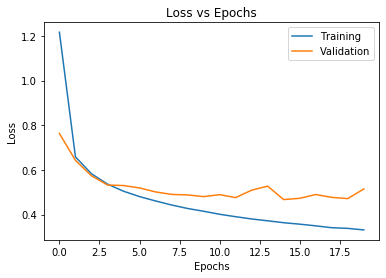

In [20]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

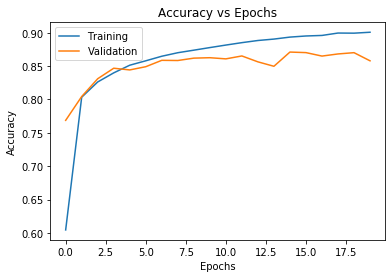

In [21]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

In [22]:
test_loss, test_accuracy = get_stats(cnn_model, gs_x_test[..., np.newaxis], y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Test loss: 0.378501832485199
Test accuracy: 0.887096107006073


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

The following function is used to load the model in case you need it.

In [23]:
def load_model(arch):
    
    if(arch == 'mlp'):
        
        path = 'mode_checkpoint/checkpoint'
        
        model = Sequential([
        Flatten(input_shape = (32, 32, 1)),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(11, activation = 'softmax')
        ])
    
        checkpoint = ModelCheckpoint(filepath = 'mode_checkpoint/checkpoint',
                                 monitor = 'val_loss',
                                 verbose = 1)
    
        e_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 6)
    
        model.compile(
            optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['acc'],
            callbacks = [checkpoint, e_stopping]
        )
        
        
    
    elif(arch == 'cnn'):
        
        path = 'cnn_model_checkpoint/checkpoint'
        
        model = Sequential([
        Conv2D(32, 3, padding = 'SAME', activation = 'relu', input_shape = (32, 32, 1)),
        MaxPooling2D(4),
        Conv2D(32, 3, padding = 'SAME', activation = 'relu'),
        Flatten(),
        Dense(11, activation = 'softmax')
        ])

        checkpoint = ModelCheckpoint(filepath = 'cnn_model_checkpoint/checkpoint',
                                     monitor = 'val_loss',
                                     verbose = 1)

        e_stopping = EarlyStopping(monitor = 'val_accuracy',
                                   patience = 6)

        model.compile(
            optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['acc', 'mae'],
            callbacks = [checkpoint, e_stopping]
        )
    
    return model.load_weights(path)

/home/ricardo/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


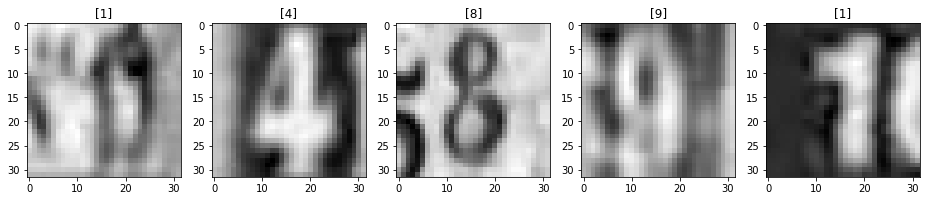

In [24]:
# Randomly choosing 5 images

fig, ax = plt.subplots(1, 5, figsize = (16,16))
indices_r = []

for i in range(5):
    index = random.randint(0, gs_x_test.shape[0] - 1)
    indices_r.append(index)
    
    image = gs_x_test[index, :, :]
    
    ax[i].imshow(image, cmap = 'gray')
    ax[i].set_title(y_test[index, ])

Let's make predictions on this randomly selected images.

In [25]:
# Getting predictions MLP
predictions = []
i = 0

for index in indices_r:
    img = gs_x_test[indices_r[i]]
    label = y_test[indices_r[i]]
    
    i = i + 1
    
    predictions.append(mlp_model.predict(img[np.newaxis, ..., np.newaxis]))

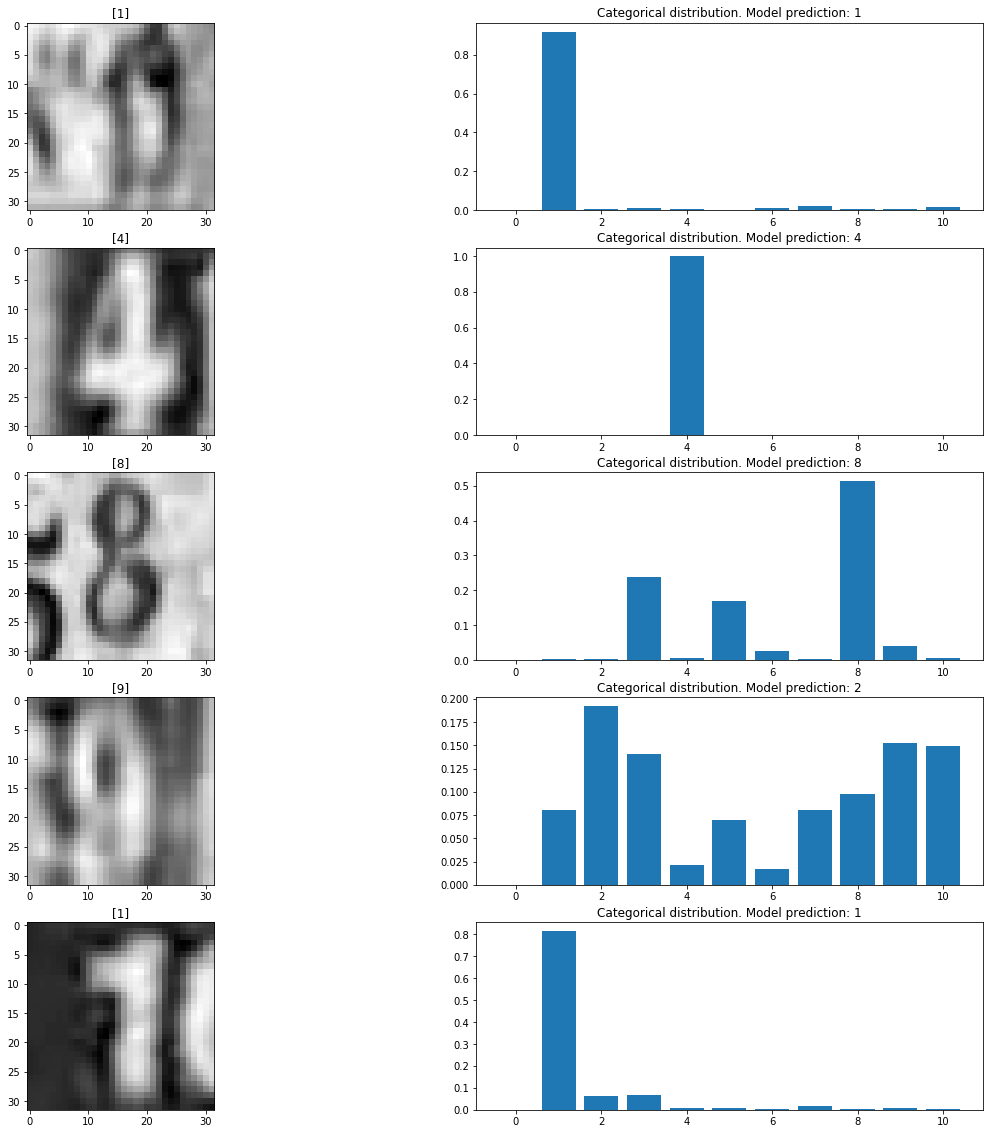

In [26]:
fig, ax = plt.subplots(5, 2, figsize = (20, 20))

for i in range(5):
    
    ax[i, 0].imshow(gs_x_test[indices_r[i]], cmap = 'gray')
    ax[i, 0].set_title(y_test[indices_r[i]])
    
    pred = predictions[i].reshape(predictions[i].shape[1])
    
    ax[i, 1].bar(np.arange(len(pred)), pred)

    ax[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(predictions[i])}")

In [27]:
# Getting predictions CNN
predictions = []
i = 0

for index in indices_r:
    img = gs_x_test[indices_r[i]]
    label = y_test[indices_r[i]]
    
    i = i + 1
    
    predictions.append(cnn_model.predict(img[np.newaxis, ..., np.newaxis]))

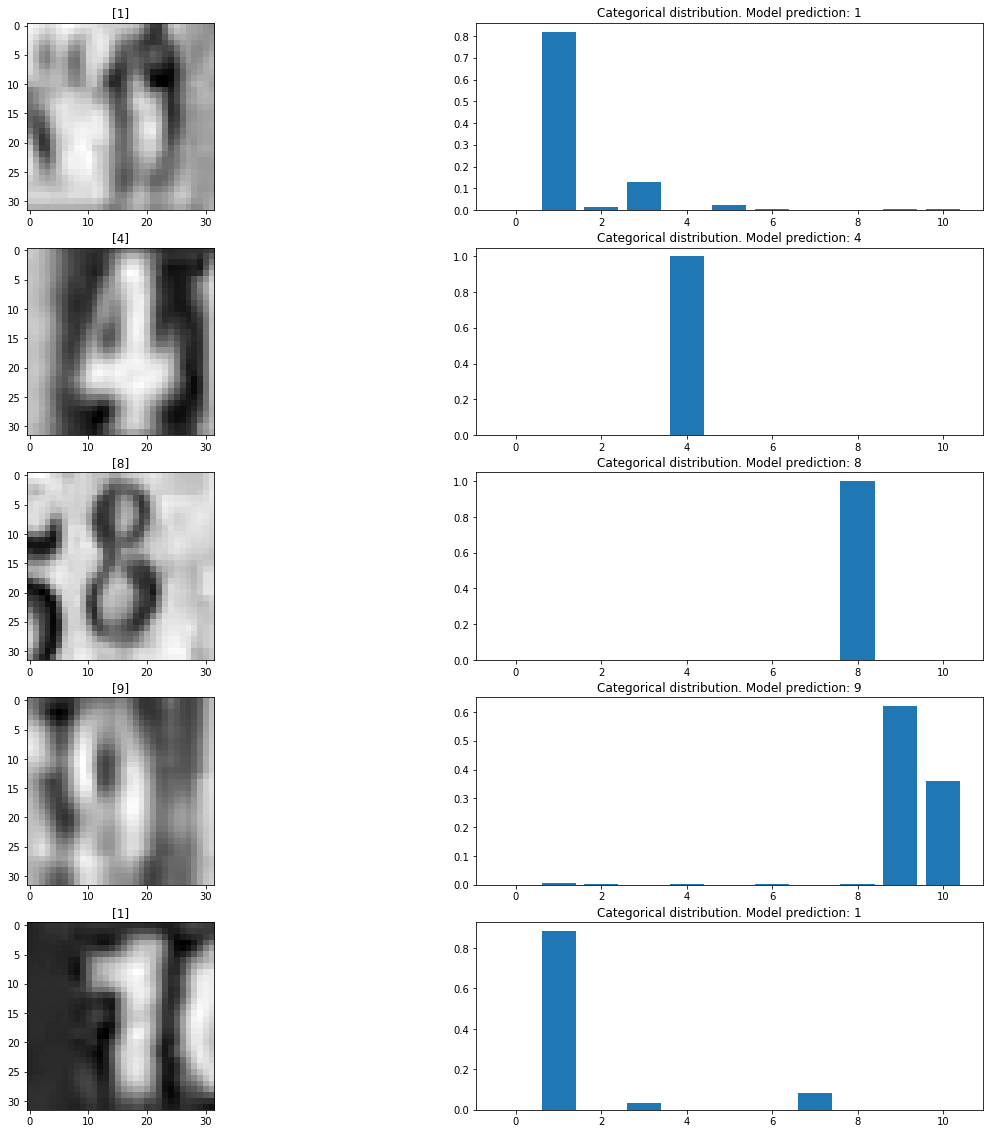

In [28]:
fig, ax = plt.subplots(5, 2, figsize = (20, 20))

for i in range(5):
    
    ax[i, 0].imshow(gs_x_test[indices_r[i]], cmap = 'gray')
    ax[i, 0].set_title(y_test[indices_r[i]])
    
    pred = predictions[i].reshape(predictions[i].shape[1])
    
    ax[i, 1].bar(np.arange(len(pred)), pred)

    ax[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(predictions[i])}")